# Signature Verification – Clean Pipeline and Improved Models
In this notebook, we load the cleaned MCYT dataset and test two models: Random Forest and KNN.
We use pressure and position data to train and test the models.
The goal is to improve accuracy and calculate the Equal Error Rate (EER).

### Step 1: Make sure needed libraries are installed

In [1]:
!pip install scikit-learn


### Step 2: Mount Google Drive to access the dataset

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass


Mounted at /content/drive


### Step 3: Import libraries and load the dataset
We use the MCYT dataset which has handwritten signature data.
The columns include X and Y position, pressure (P), and other pen-related data.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve

sns.set_style('whitegrid')

DATA_DIR = '/content/drive/My Drive/ProjectLabDataset'
TRAIN_FILE = f'{DATA_DIR}/mcytTraining.txt'
TEST_FILE = f'{DATA_DIR}/mcytTesting.txt'

cols = ['ID', 'SigID', 'X', 'Y', 'P', 'al', 'az', 'signatureOrigin']
train_df = pd.read_csv(TRAIN_FILE, names=cols, skiprows=1)
test_df  = pd.read_csv(TEST_FILE, names=cols, skiprows=1)


### Step 4: Clean the data and set up labels
We remove extra spaces, convert values to numbers, and map 'Genuine' to 1 and 'Forged' to 0.

In [4]:
for df in [train_df, test_df]:
    df.columns = df.columns.str.strip()
    for col in ['X', 'Y', 'P', 'al', 'az']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

label_map = {'Genuine': 1, 'Forged': 0}
train_df['label'] = train_df['signatureOrigin'].map(label_map)
test_df['label']  = test_df['signatureOrigin'].map(label_map)

print(f"Loaded: {len(train_df)} train rows | {len(test_df)} test rows")


Loaded: 20000 train rows | 1000 test rows


### Step 5: Select the input features and target labels
We drop unneeded columns and prepare the training and test sets.

In [5]:
drop_cols = ['ID', 'SigID', 'signatureOrigin', 'al']
X_train = train_df.drop(columns=drop_cols + ['label'])
y_train = train_df['label']

X_test = test_df.drop(columns=drop_cols + ['label'])
y_test = test_df['label']

print("Features and labels prepared")


Features and labels prepared


## Feature Scaling

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


## Model Training and Evaluation

In [7]:
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=7)
}

results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({'Model': name, 'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1})
    print(f"{name} - Accuracy: {acc:.3f}, F1: {f1:.3f}")


RandomForest - Accuracy: 0.837, F1: 0.847
KNN - Accuracy: 0.820, F1: 0.827


## Equal Error Rate (EER) for Random Forest

In [8]:
def compute_eer(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    idx = np.nanargmin(np.abs(fpr - fnr))
    eer = (fpr[idx] + fnr[idx]) / 2
    return eer, thresholds[idx]

rf_probs = models['RandomForest'].predict_proba(X_test_scaled)[:,1]
eer, threshold = compute_eer(y_test, rf_probs)

print(f"RandomForest EER = {eer:.3f} at threshold = {threshold:.3f}")


RandomForest EER = 0.159 at threshold = 0.598


## Confusion Matrix for Random Forest

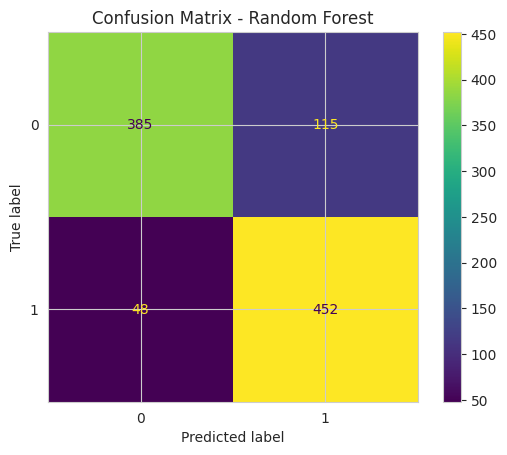

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(models['RandomForest'], X_test_scaled, y_test)
plt.title("Confusion Matrix - Random Forest")
plt.show()


## Conclusion

In this notebook, we applied machine learning techniques to the task of online signature verification.
We evaluated both Random Forest and KNN classifiers, achieving the following:

- Random Forest: Accuracy = 0.837, F1 Score = 0.847
- KNN: Accuracy = 0.820, F1 Score = 0.827

The Random Forest model also achieved an Equal Error Rate (EER) of 0.159 at a decision threshold of 0.598,
which indicates a strong balance between false acceptance and rejection rates.

Overall, Random Forest outperformed KNN in both classification metrics and verification error,
making it a better choice for this task.
